<a href="https://colab.research.google.com/github/Triniti0/klasifikasi-penyakit-daun-cabai/blob/main/Eksperimen_Optimasi_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eksperimen Optimasi 1

Inisiasi libary dan konfigurasi awal

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
import numpy as np
import os
import time
import pandas as pd
import json
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

Mounted at /content/drive


In [ ]:
SAVE_DIR = "/content/drive/MyDrive/feature_extraction_exp"
os.makedirs(SAVE_DIR, exist_ok=True)

RESULTS_FILE = os.path.join(SAVE_DIR, "grid_results.csv")
BEST_MODEL_PATH = os.path.join(SAVE_DIR, "best_model.h5")
BEST_MODEL_INFO = os.path.join(SAVE_DIR, "best_model_info.json")

IMG_SIZE = 224
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
def load_dataset(batch_size):

    train_ds = tf.keras.utils.image_dataset_from_directory(
        "/content/drive/MyDrive/Seminar Hasil/dataset_processed/train",
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        "/content/drive/MyDrive/Seminar Hasil/dataset_processed/val",
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size
    )

    test_ds = tf.keras.utils.image_dataset_from_directory(
        "/content/drive/MyDrive/Seminar Hasil/dataset_processed/test",
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        shuffle=False
    )

    class_names = train_ds.class_names

    def preprocess(x, y):
        return preprocess_input(x), y

    train_ds = train_ds.map(preprocess).prefetch(AUTOTUNE)
    val_ds = val_ds.map(preprocess).prefetch(AUTOTUNE)
    test_ds = test_ds.map(preprocess).prefetch(AUTOTUNE)

    return train_ds, val_ds, test_ds, class_names

# Membangun Model

In [ ]:
def build_feature_extraction(dropout_rate, learning_rate, optimizer_name, num_classes):

    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    base_model.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)

    if optimizer_name == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Hyperparameter Tuning dengan Grid Search

In [ ]:
#Konfigurasi Grid Search
learning_rates = [1e-3, 1e-2]
optimizers = ["adam", "rmsprop"]
batch_sizes = [32, 64]
dropouts = [0.3, 0.4, 0.5]
epochs = 50  # max epoch, EarlyStopping aktif

load checkpoin (kalau pelatihan berhenti)

In [ ]:
if os.path.exists(RESULTS_FILE):
    results_df = pd.read_csv(RESULTS_FILE)
    completed = set(results_df["Config_ID"])
    best_val_acc = results_df["Val Accuracy"].max()
    print("Resume from previous session.")
else:
    results_df = pd.DataFrame()
    completed = set()
    best_val_acc = 0
    print("Start new experiment.")

Start new experiment.


training loop grid search

In [ ]:
def config_id(lr, opt, bs, dr):
    return f"LR{lr}_OPT{opt}_BS{bs}_DR{dr}"

for lr in learning_rates:
    for opt in optimizers:
        for bs in batch_sizes:
            for dr in dropouts:

                cid = config_id(lr, opt, bs, dr)

                if cid in completed:
                    print(f"Skip {cid}")
                    continue

                print(f"\nRunning {cid}")

                train_ds, val_ds, test_ds, class_names = load_dataset(bs)
                model = build_feature_extraction(dr, lr, opt, len(class_names))

                callbacks = [
                    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
                    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)
                ]

                start_time = time.time()

                model.fit(
                    train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=callbacks,
                    verbose=1
                )

                training_time = time.time() - start_time
                val_loss, val_acc = model.evaluate(val_ds, verbose=0)

                if val_acc > best_val_acc:
                    best_val_acc = val_acc

                    best_model_name = f"best_{cid}.h5"
                    BEST_MODEL_PATH = os.path.join(SAVE_DIR, best_model_name)

                    model.save(BEST_MODEL_PATH)

                    best_model_metadata = {
                        "Config_ID": cid,
                        "Learning Rate": lr,
                        "Optimizer": opt,
                        "Batch Size": bs,
                        "Dropout": dr,
                        "Validation Accuracy": float(val_acc),
                        "Model Path": BEST_MODEL_PATH
                    }

                    with open(BEST_MODEL_INFO, "w") as f:
                        json.dump(best_model_metadata, f, indent=4)

                    print("New Best Model Saved:", best_model_name)


                new_row = {
                    "Config_ID": cid,
                    "Learning Rate": lr,
                    "Optimizer": opt,
                    "Batch Size": bs,
                    "Dropout": dr,
                    "Val Accuracy": val_acc,
                    "Training Time": training_time
                }

                results_df = pd.concat([results_df, pd.DataFrame([new_row])])
                results_df.to_csv(RESULTS_FILE, index=False)

                print(f"Finished {cid}")


Running LR0.001_OPTadam_BS32_DR0.3
Found 11704 files belonging to 8 classes.
Found 617 files belonging to 8 classes.
Found 620 files belonging to 8 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1112s 3s/step - accuracy: 0.8269 - loss: 0.5113 - val_accuracy: 0.9676 - val_loss: 0.0857 - learning_rate: 0.0010
Epoch 2/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9800 - loss: 0.0660 - val_accuracy: 0.9757 - val_loss: 0.0737 - learning_rate: 0.0010
Epoch 3/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9897 - loss: 0.0363 - val_accuracy: 0.9757 - val_loss: 0.0849 - learning_rate: 0.0010
Epoch 4/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9914 - loss: 0.0272 - val_accuracy: 0.9838 - val_loss: 0.0628 - learning_rate: 0.0010
Epoch 5/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9916 - loss: 0.0253 - val_accuracy: 0.9741 - val_loss: 0.0960 - learning_rate: 0.0010
Epoch 6/50
366/366 ━━━━

New Best Model Saved: best_LR0.001_OPTadam_BS32_DR0.3.h5
Finished LR0.001_OPTadam_BS32_DR0.3

Running LR0.001_OPTadam_BS32_DR0.4
Found 11704 files belonging to 8 classes.
Found 617 files belonging to 8 classes.
Found 620 files belonging to 8 classes.
Epoch 1/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 40s 87ms/step - accuracy: 0.8072 - loss: 0.5760 - val_accuracy: 0.9611 - val_loss: 0.1142 - learning_rate: 0.0010
Epoch 2/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9732 - loss: 0.0900 - val_accuracy: 0.9724 - val_loss: 0.0800 - learning_rate: 0.0010
Epoch 3/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9826 - loss: 0.0545 - val_accuracy: 0.9757 - val_loss: 0.0774 - learning_rate: 0.0010
Epoch 4/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9895 - loss: 0.0394 - val_accuracy: 0.9822 - val_loss: 0.0669 - learning_rate: 0.0010
Epoch 5/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9912 - loss: 0.0321 - val_accuracy: 0.9838 - val_loss: 0.0625 - l

Rekap Hasil Grid Search

In [ ]:
# Load results_df if it hasn't been loaded or if the notebook was reset
if 'results_df' not in locals() or results_df.empty:
    if os.path.exists(RESULTS_FILE):
        results_df = pd.read_csv(RESULTS_FILE)
    else:
        print("Results file not found. Cannot determine best model configuration.")

# Get the row with the highest validation accuracy
best_model_config = results_df.sort_values(by='Val Accuracy', ascending=False).iloc[0]

print("Hyperparameters of the Best Model:")
print(best_model_config[["Learning Rate", "Optimizer", "Batch Size", "Dropout", "Val Accuracy"]])

Hyperparameters of the Best Model:
Learning Rate       0.001
Optimizer            adam
Batch Size             32
Dropout               0.3
Val Accuracy     0.985413
Name: 0, dtype: object


# Evaluasi Hasil

dilakukan pada test set

In [ ]:
#load best model
with open(BEST_MODEL_INFO, "r") as f:
    best_info = json.load(f)

print("\n===== BEST MODEL INFORMATION =====")
for key, value in best_info.items():
    print(f"{key}: {value}")

best_model = tf.keras.models.load_model(best_info["Model Path"])


===== BEST MODEL INFORMATION =====
Config_ID: LR0.001_OPTadam_BS32_DR0.3
Learning Rate: 0.001
Optimizer: adam
Batch Size: 32
Dropout: 0.3
Validation Accuracy: 0.9854133129119873
Model Path: /content/drive/MyDrive/feature_extraction_exp/best_LR0.001_OPTadam_BS32_DR0.3.h5


In [ ]:
train_ds, val_ds, test_ds, class_names = load_dataset(best_info["Batch Size"])

train_loss, train_acc = best_model.evaluate(train_ds, verbose=0)
val_loss, val_acc = best_model.evaluate(val_ds, verbose=0)
test_loss, test_acc = best_model.evaluate(test_ds, verbose=0)

print("\n===== PERFORMANCE SUMMARY =====")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Found 11704 files belonging to 8 classes.
Found 617 files belonging to 8 classes.
Found 620 files belonging to 8 classes.

===== PERFORMANCE SUMMARY =====
Train Accuracy: 0.9996
Validation Accuracy: 0.9854
Test Accuracy: 0.9903


In [ ]:
print("\n===== FITTING DIAGNOSIS =====")

if train_acc - val_acc > 0.10:
    print("⚠ Indikasi Overfitting (Train jauh lebih tinggi dari Validation)")
elif val_acc > train_acc:
    print("⚠ Kemungkinan Underfitting atau training belum optimal")
else:
    print("✔ Model relatif stabil (tidak ada indikasi kuat over/underfitting)")


===== FITTING DIAGNOSIS =====
✔ Model relatif stabil (tidak ada indikasi kuat over/underfitting)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
                      precision    recall  f1-score   support

         Anthracnose       1.00      1.00      1.00        25
      Bacterial Spot       0.92      0.96      0.94        24
Cercospora Leaf Spot       1.00      0.93      0.96      

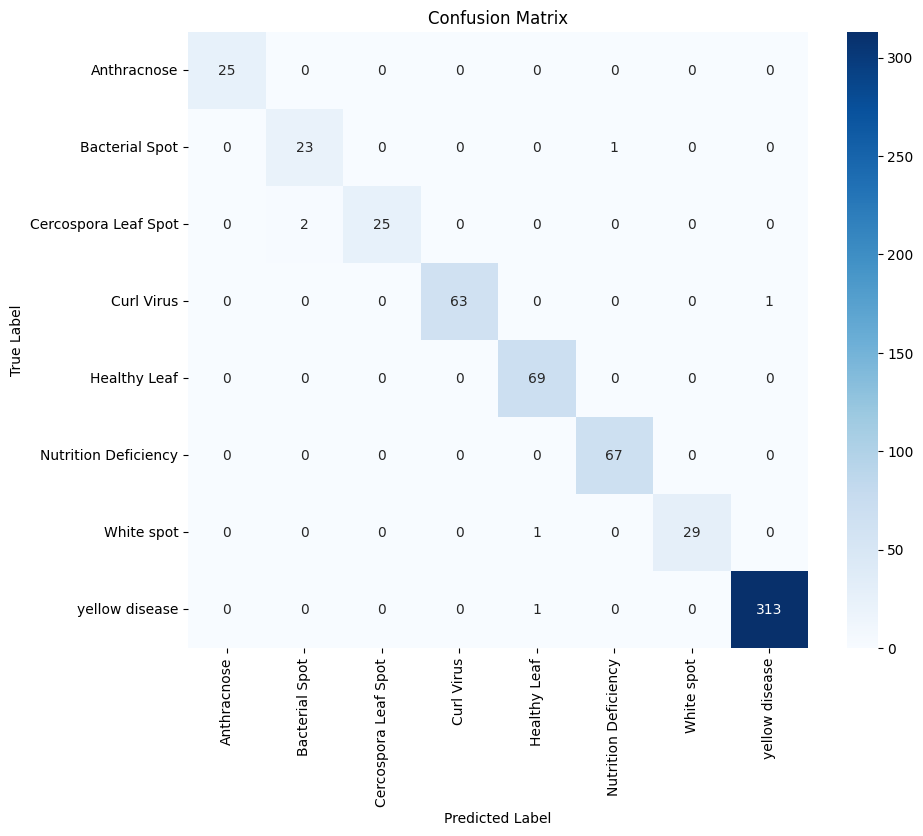

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#confusion matrix
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = best_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#waktu inferensi
sample = next(iter(test_ds))[0]

start = time.time()
_ = best_model.predict(sample)
inference_time = (time.time() - start) / len(sample)

print("Inference Time per Image:", inference_time)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Inference Time per Image: 0.003566041588783264


In [ ]:
#ukuran file model
size_mb = os.path.getsize(best_info["Model Path"]) / (1024*1024)
print("Model Size (MB):", size_mb)

Model Size (MB): 11.017669677734375


In [ ]:
print(best_info)

# Extract best model parameters from best_info
best_lr = best_info['Learning Rate']
best_opt = best_info['Optimizer']
best_bs = best_info['Batch Size']
best_dr = best_info['Dropout']

# Load dataset with the best batch size
train_ds_best, val_ds_best, test_ds_best, class_names_best = load_dataset(best_bs)

# Build the best model architecture using the correct function
best_model_for_history = build_feature_extraction(best_dr, best_lr, best_opt, len(class_names_best))

# Re-initialize the weights to ensure we get the history from scratch
# If we don't re-initialize, it will continue training from the loaded 'best_model'
# This assumes the user wants the full training curve, not continued training.
# A simple way to re-initialize weights is to rebuild the model.

# Setup callbacks for the best model's training, consistent with grid search
callbacks_best = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)
]

print(f"\nRetraining best model (Config ID: {best_info['Config_ID']}) to capture training history...")

# Train the model and capture history
retrained_history = best_model_for_history.fit(
    train_ds_best,
    validation_data=val_ds_best,
    epochs=epochs, # Use the same number of epochs as in grid search
    callbacks=callbacks_best,
    verbose=1
)

print("Retraining complete. History captured.")

{'Config_ID': 'LR0.001_OPTadam_BS32_DR0.3', 'Learning Rate': 0.001, 'Optimizer': 'adam', 'Batch Size': 32, 'Dropout': 0.3, 'Validation Accuracy': 0.9854133129119873, 'Model Path': '/content/drive/MyDrive/feature_extraction_exp/best_LR0.001_OPTadam_BS32_DR0.3.h5'}
Found 11704 files belonging to 8 classes.
Found 617 files belonging to 8 classes.
Found 620 files belonging to 8 classes.

Retraining best model (Config ID: LR0.001_OPTadam_BS32_DR0.3) to capture training history...
Epoch 1/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.8257 - loss: 0.5222 - val_accuracy: 0.9530 - val_loss: 0.1178 - learning_rate: 0.0010
Epoch 2/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9812 - loss: 0.0627 - val_accuracy: 0.9611 - val_loss: 0.1097 - learning_rate: 0.0010
Epoch 3/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9889 - loss: 0.0378 - val_accuracy: 0.9757 - val_loss: 0.0843 - learning_rate: 0.0010
Epoch 4/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - ac

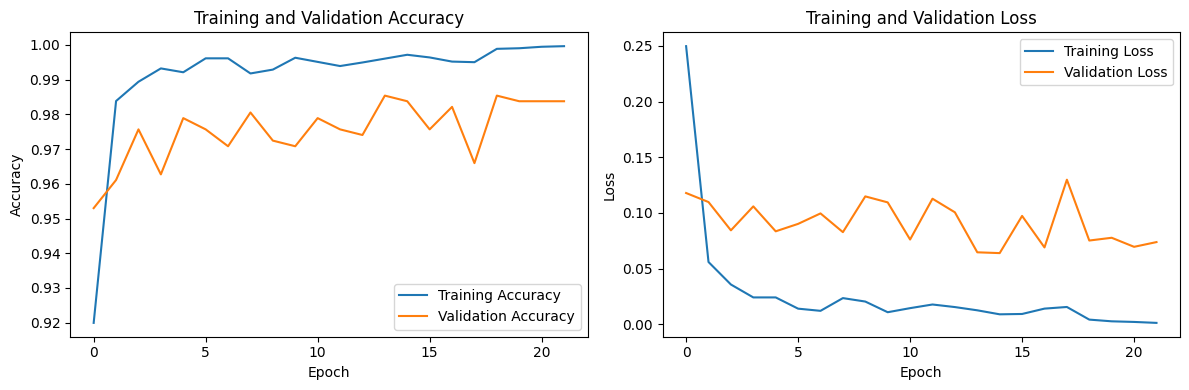

In [ ]:
history_dict = retrained_history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()